### Import data

In [ ]:
include("importData.jl")
include("DDEmodel.jl")
include("plot.jl")

# import data from the path
pop, g2, g1, g1_0, g2_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv"); # in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0

# This is to load the estimated parameters to be used as "initial guess"
param_lap_dde = CSV.read(".//ddeParams//params_lap_DDE.csv")

# initial guesses for the parameters
lap = convert(Matrix, param_lap_dde[1:7,2:end]);

### Estimate 

[0.03791, 0.03054, 0.53348, 15.9698, 11.4502, 0.00064, 0.001]

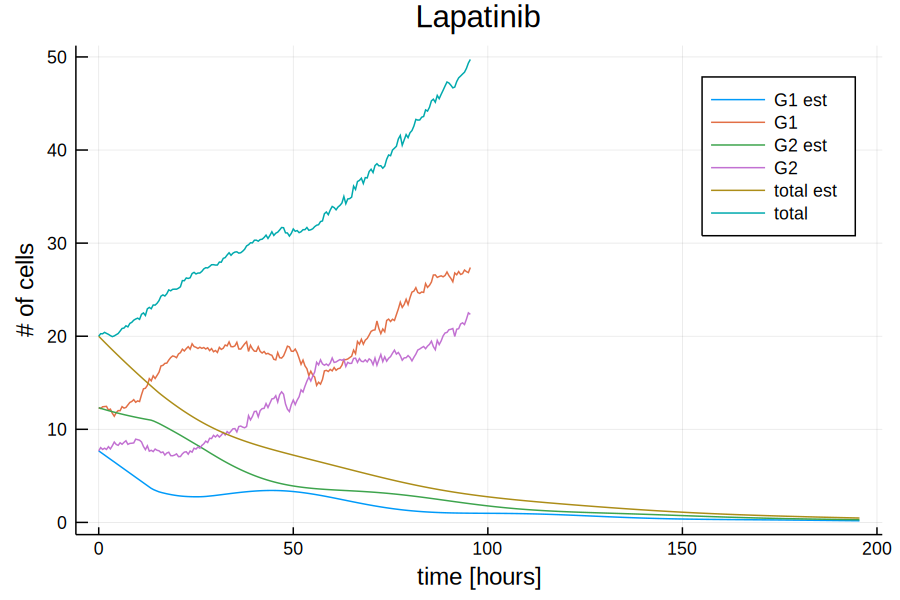

In [11]:
# i is the number of the column we are using from the data (# of trial)
i = 4

print(lap[:, 3])
# initial guess
p = [0.03791, 0.03054, 15.9698, 11.4502, 0.00064, 0.001]
# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = [0.015, 0.003, 3.0, 7.0, 0.0001, 0.0001]
upp = [0.075, 0.075, 30.0, 100.0, 0.05, 0.05]

# Estimating the parameters for trial i
params = optimIt(p, low, upp, i, g1, g2)

# Plotting the long-term prediction along with the data for trial i
plotIt(params, g1, g2, g1_0, g2_0, pop, i, "Lapatinib")

### Plot parameters against drug concentrations

In [4]:
# Reading the file containing params
param_lap_dde = CSV.read(".//ddeParams//params_lap_DDE.csv")
param_gem_dde = CSV.read(".//ddeParams//params_gem_DDE.csv")
param_dox_dde = CSV.read(".//ddeParams//params_dox_DDE.csv")
param_taxol1_dde = CSV.read(".//ddeParams//params_taxol1_DDE.csv")
param_tax2_dde = CSV.read(".//ddeParams//params_tax2_DDE.csv")

# Convert the DataFrame to Matrix for plotting
lap = convert(Matrix, param_lap_dde[:,2:end])
gem = convert(Matrix, param_gem_dde[:,2:end])
dox = convert(Matrix, param_dox_dde[:,2:end])
tax = convert(Matrix, param_taxol1_dde[:,2:end])

8×8 Array{Float64,2}:
  0.269324     0.253443     0.270419    …   0.687241    0.149286    0.0
  0.181391     0.179939     0.180216        0.520756    0.0694509   0.0
  1.28954      0.12249      0.884038        0.0109564   0.0109982   0.0
 22.0043      21.722       21.3319         11.8        37.5288      0.0
  8.56809      8.47903      8.84268         9.27946    12.243       0.0
  0.00328715   0.00185985   0.00240285  …   0.0496551   0.0195683   0.0
  0.0995473    0.10107      0.106588        0.535322    0.125117    0.0
  0.0          0.1          1.0             5.0         7.5        15.0

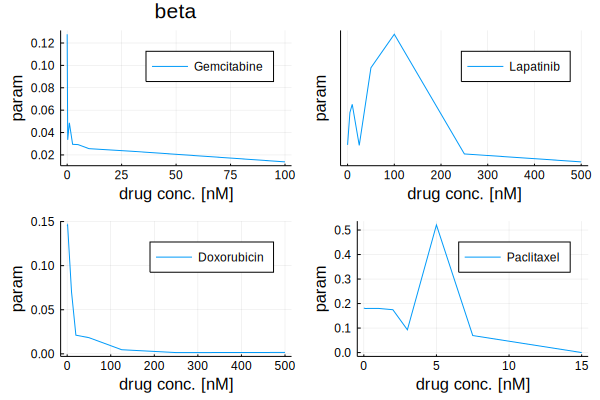

In [5]:
plot_param_conc(lap, gem, dox, tax, 2 , "beta")